In [2]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()


# get the code
import sys
sys.path.append('../code')
from plot import plot_snp
from rollingCNV import one_col_rolling
from cluster import center_data

home = '/Users/mahtin'
# home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# tool-specific paths
shell_path = "../shell"
# 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

In [3]:
cnvPON_path

'/Users/mahtin/mount/scratch/develop/PONcoverage/chromCov'

## get the coverage and SNP data

In [4]:
sample = "01_A"
snp_df = pd.read_csv(os.path.join(output_path, f'rollingCNV/{sample}.snpcov.csv'), sep='\t')
rolling_cov_df = pd.read_csv(os.path.join(output_path, f'rollingCNV/{sample}.rollcov.csv'), sep='\t')

In [5]:
snp_df[:10]

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF
0,chr1,14930,836,836,1.747734,NaN,NaN,64.0,0.505,0.046875
1,chr1,15820,991,991,0.435176,0.161229,0.0,13.0,2.401,0.846154
2,chr1,16949,1410,1410,0.789243,0.161229,0.0,182.0,0.006,0.038462
3,chr1,17365,1689,1689,1.040816,0.161229,0.0,285.0,0.666,0.140351
4,chr1,17375,1699,1699,1.004858,0.161229,0.0,353.0,1.526,0.065156
5,chr1,17379,1703,1703,0.990475,0.161229,0.0,363.0,1.578,0.093664
6,chr1,17384,1708,1708,0.972496,0.161229,0.0,388.0,0.494,0.002577
7,chr1,17452,1776,1776,0.823694,0.161229,0.0,529.0,0.178,0.001890
8,chr1,17614,1938,1938,0.940359,0.161229,0.0,216.0,1.016,0.171296
9,chr1,69270,2994,2994,0.443454,0.161229,0.0,34.0,0.001,1.000000


### visualize the data

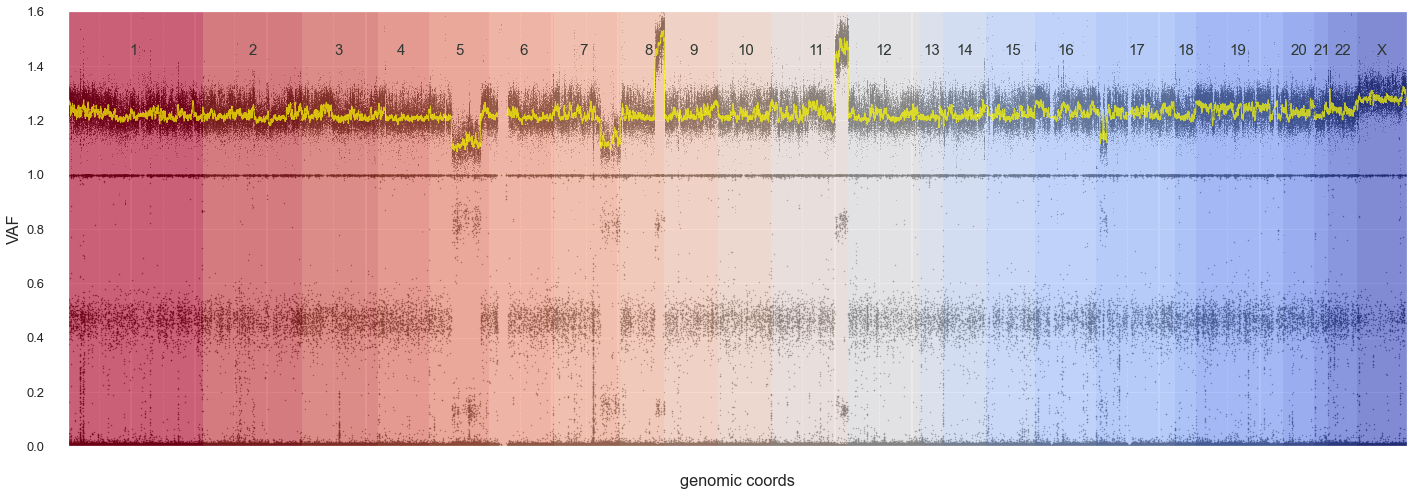

In [6]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=.2,
            color='black',
            alpha=.7
        )
    )
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='', **fig_params)

## heteroSNP rolling window
+ #### first, the center cluster has to be fitted via clustering to identify the centers for mean correction

In [13]:
config = {
    'debug': True, # also export the left and right rolling window values (L/R)
    'coverage': {
        'filter': dict(
            min_cov = 30,
            min_PON_cov = 50,
            max_PON_std = 100,
        ),
        'normalize':False,
        'center': True,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':100
            }
        }
    },
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=30,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': 0.5,
        'data': {
            'absVAF': {
                'sum': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'std': 20
            }
        }
    }
}

snp_df = center_data(snp_df, config)

GMM using 25 inits: center size 19578 meanVAF = 0.46 meanCov=0.0
log2ratio centered around 6.474582924057241e-07


### extract important features from SNPdata
+ absVAF is distance of heteroSNP to 0.5
+ deltaVAF is difference between adjacent SNPs

In [8]:
def expand_SNPdata(snp_df, config):
    '''
    retrieve a few data columns locally to use rolling windows on
    this needs to be done chromosome-wise in order to avoid gap effects
    '''

    # split the params dict for easier access
    params = config['heteroSNP']
    filter_params = params['filter']
    data_params = params['data']
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF']
    snp_df = snp_df.query('@VAFmin < VAF < @VAFmax')
    
    # get the new features from VAFs
    snp_df.loc[:,'absVAF'] = np.abs(snp_df['VAF'] - 0.5) * 2
    # get the local VAF difference chrom based
    dfs = []
    for chrom in snp_df['Chr'].unique():
        chrom_df = snp_df.query('Chr == @chrom')
        chrom_df.loc[:, 'deltaVAF'] = np.abs(chrom_df['VAF'] - chrom_df.shift(1)['VAF']).fillna(0)
        dfs.append(chrom_df)
    snp_df = pd.concat(dfs).sort_values('FullExonPos')
    return snp_df

In [31]:
snp2_df = expand_SNPdata(snp_df, config)
snp2_df

/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF,absVAF,deltaVAF
1,chr1,15820,991,991,0.435176,0.294705,0.0,13.0,2.401,0.846154,0.692308,0.000000
3,chr1,17365,1689,1689,1.040816,0.294705,0.0,285.0,0.666,0.140351,0.719298,0.705803
4,chr1,17375,1699,1699,1.004858,0.294705,0.0,353.0,1.526,0.065156,0.869688,0.075195
5,chr1,17379,1703,1703,0.990475,0.294705,0.0,363.0,1.578,0.093664,0.812672,0.028508
8,chr1,17614,1938,1938,0.940359,0.294705,0.0,216.0,1.016,0.171296,0.657408,0.077632
...,...,...,...,...,...,...,...,...,...,...,...,...
336263,chrX,156023260,49469650,1835187,-0.667568,0.212755,0.0,25.0,0.950,0.880000,0.760000,0.023226
336264,chrX,156023266,49469656,1835193,-0.655721,0.212728,0.0,25.0,0.930,0.880000,0.760000,0.000000
336265,chrX,156024203,49469886,1835423,0.148033,0.211671,0.0,53.0,0.392,0.132075,0.735850,0.747925
336266,chrX,156024239,49469922,1835459,0.160322,0.211506,0.0,56.0,0.203,0.267857,0.464286,0.135782


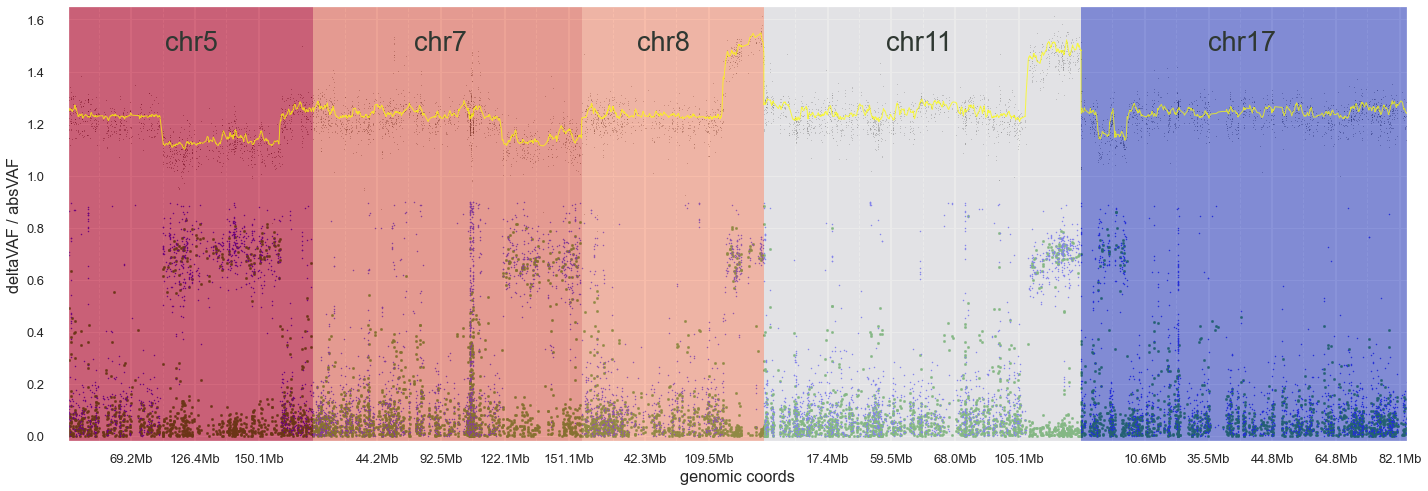

In [10]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.02,1.05),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=1,
            alpha=1
        ))
deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='green',
            s=5,
            alpha=1
        ))

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp2_df, snp_plots=[deltavaf, absvaf], cov_plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

In [14]:
def rolling_snp(snp_df, config):
    '''
    cycle through the chroms and perform rolling window computations of snp data set in config
    '''
    
    # split the params dict for easier access
    params = config['heteroSNP']
    filter_params = params['filter']
    data_params = params['data']
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF'] 
    minDepth = filter_params['minDepth']
    minEBscore = filter_params['minEB']
    
    # cycle through chroms for 
    chrom_dfs = []
    for chrom in snp_df['Chr'].unique():
        # restrict to chrom
        chrom_df = snp_df.query('Chr == @chrom').sort_values('FullExonPos')        
        # filter df
        filter_df = snp_df.query('Depth >= @minDepth and EBscore > @minEBscore') #.query('@VAFmin < VAF < @VAFmax and 
        for data_col in data_params.keys():
            for agg in data_params[data_col].keys():
                window_size = data_params[data_col][agg]
                expand_limit = int(params['expand'] * window_size)
                # print(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_df, data_col, agg, window_size=window_size, expand_limit=expand_limit, normalize=params['normalize'], debug=config['debug'])
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    return df

### test rolling windows

In [33]:
snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'sum': 20
            }
        }
    }   
}
config.update(snp_config)
snp3_df = rolling_snp(snp2_df, config)
snp3_df[:50]

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF,absVAF,deltaVAF,absVAFsum,absVAFsumDiff,absVAFsumL,absVAFsumR
0,chr1,15820,991,991,0.435176,0.294705,0.000000e+00,13.0,2.401,0.846154,0.692308,0.000000,NaN,NaN,NaN,NaN
1,chr1,17365,1689,1689,1.040816,0.294705,0.000000e+00,285.0,0.666,0.140351,0.719298,0.705803,NaN,NaN,NaN,NaN
2,chr1,17375,1699,1699,1.004858,0.294705,0.000000e+00,353.0,1.526,0.065156,0.869688,0.075195,NaN,NaN,NaN,NaN
3,chr1,17379,1703,1703,0.990475,0.294705,0.000000e+00,363.0,1.578,0.093664,0.812672,0.028508,NaN,NaN,NaN,NaN
4,chr1,17614,1938,1938,0.940359,0.294705,0.000000e+00,216.0,1.016,0.171296,0.657408,0.077632,NaN,NaN,NaN,NaN
5,chr1,69897,3558,3558,1.430673,0.294705,0.000000e+00,31.0,0.020,0.645161,0.290322,0.473865,NaN,NaN,NaN,NaN
6,chr1,69968,3629,3629,1.115469,0.294705,0.000000e+00,32.0,1.149,0.093750,0.812500,0.551411,NaN,NaN,NaN,NaN
7,chr1,946247,14293,14292,0.022146,0.318441,0.000000e+00,253.0,0.315,0.505929,0.011858,0.412179,NaN,NaN,NaN,NaN
8,chr1,965125,20103,20127,-0.180766,0.371601,0.000000e+00,175.0,1.138,0.502857,0.005714,0.003072,NaN,NaN,NaN,NaN
9,chr1,1020217,27693,27693,0.386200,0.333187,1.875422e-05,60.0,0.270,0.483333,0.033334,0.019524,NaN,NaN,NaN,NaN


## optimizing rolling windows

### absVAF
+ mean
+ std

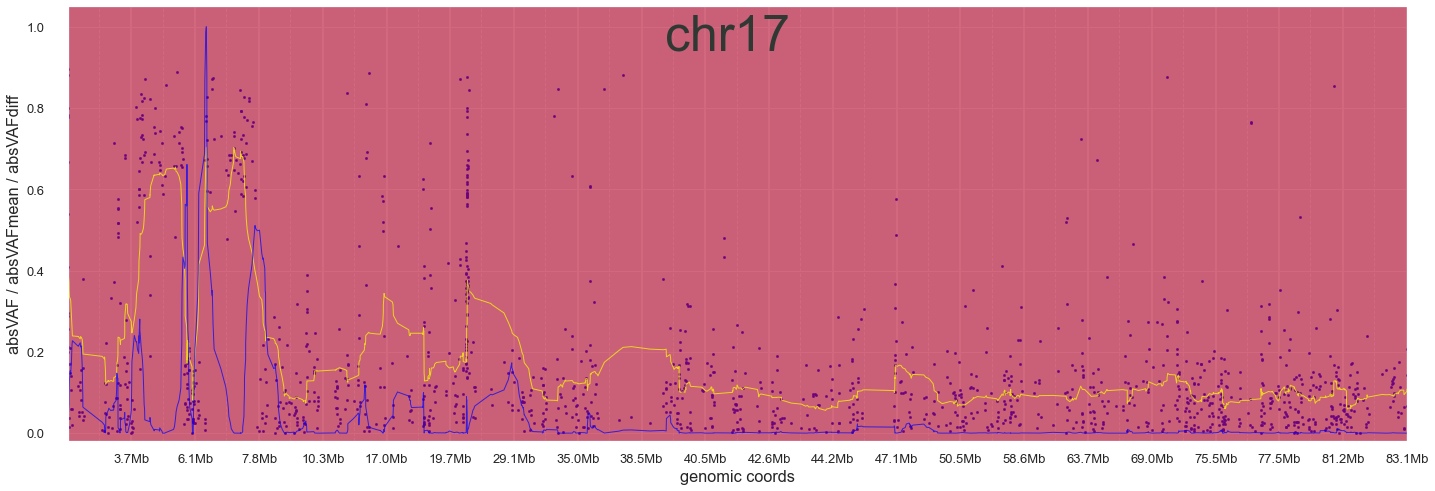

In [15]:
absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
absvafmean = dict(
        title='absVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafmeandiff = dict(
        title='absVAFdiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'mean':20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_snp(snp2_df, config)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=[absvaf,absvafmean, absvafmeandiff], chroms=chroms, region='chr17', **fig_params)

In [32]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.02,1.05),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)



absvafsum = dict(
        title='absVAFsum',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFsum',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafsumdiff = dict(
        title='absVAFsumdiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFsumDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'sum': 20
            }
        }
    }   
}
config.update(snp_config)
snp3_df = rolling_snp(snp2_df, config)
snp3_df[:50]

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF,absVAF,deltaVAF,absVAFsum,absVAFsumDiff,absVAFsumL,absVAFsumR
0,chr1,15820,991,991,0.435176,0.294705,0.000000e+00,13.0,2.401,0.846154,0.692308,0.000000,NaN,NaN,NaN,NaN
1,chr1,17365,1689,1689,1.040816,0.294705,0.000000e+00,285.0,0.666,0.140351,0.719298,0.705803,NaN,NaN,NaN,NaN
2,chr1,17375,1699,1699,1.004858,0.294705,0.000000e+00,353.0,1.526,0.065156,0.869688,0.075195,NaN,NaN,NaN,NaN
3,chr1,17379,1703,1703,0.990475,0.294705,0.000000e+00,363.0,1.578,0.093664,0.812672,0.028508,NaN,NaN,NaN,NaN
4,chr1,17614,1938,1938,0.940359,0.294705,0.000000e+00,216.0,1.016,0.171296,0.657408,0.077632,NaN,NaN,NaN,NaN
5,chr1,69897,3558,3558,1.430673,0.294705,0.000000e+00,31.0,0.020,0.645161,0.290322,0.473865,NaN,NaN,NaN,NaN
6,chr1,69968,3629,3629,1.115469,0.294705,0.000000e+00,32.0,1.149,0.093750,0.812500,0.551411,NaN,NaN,NaN,NaN
7,chr1,946247,14293,14292,0.022146,0.318441,0.000000e+00,253.0,0.315,0.505929,0.011858,0.412179,NaN,NaN,NaN,NaN
8,chr1,965125,20103,20127,-0.180766,0.371601,0.000000e+00,175.0,1.138,0.502857,0.005714,0.003072,NaN,NaN,NaN,NaN
9,chr1,1020217,27693,27693,0.386200,0.333187,1.875422e-05,60.0,0.270,0.483333,0.033334,0.019524,NaN,NaN,NaN,NaN


In [ ]:
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=[absvaf,absvafsum, absvafsumdiff], chroms=chroms, region='chr17', **fig_params)

In [ ]:
df[:20]

In [ ]:
df['sum'] = df['absVAF'].rolling(5).agg('sum')
df[:20]